<a href="https://colab.research.google.com/github/Maxouuu4/test_git/blob/main/math0487_nb6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 6 : **Régression linéaire**

##Objectifs 🎯

Les objectifs de ce notebook sont les suivants :
*   *comprendre* le concept de modèle prédictif et de régression linéaire,
*   *comprendre* la distinction entre le modèle linéaire gaussien et des moindres carrés,
*   *appliquer* une régression linéaire dans un cas pratique et *comprendre* ses limitations sous-jacentes,
*   *comprendre* le concept de régression logistique,
*   *appliquer* une régression logistique dans un cas pratique.

#Régression linéaire: de quoi parle-t-on ? 🤔

### Modèle Prédictif:

Jusqu'à présent, nous nous sommes principalement intéressés à décrire nos données. Plus précisément, nous désirions identifier les paramètres d'une distribution qui semble générer les observations que nous avons sous les yeux.

Désormais, à la place de **décrire**, nous cherchons à **prédire** à l'aide des modèles prédictifs. Un modèle prédictif est un modèle qui essaie de prédire la valeur prise par une variable aléatoire $Y$ à partir d'une ou plusieurs autres variables $\mathbf{X}$. On discute dans ce notebook d'*apprentissage conditionnel* dont le but est d'obtenir un modèle prédictif $\mu(\mathbf{x})$ modélisant l'espérance conditionnelle:

$$\mu(\mathbf{x}) = E(Y|\mathbf{X}=\mathbf{x}).$$

Ces modèles sont omniprésents en pratique. En pratique:

$\hspace{1cm}$ 🩺 Certains s'en servent afin de prédire le taux de survie ($Y$) d'un patient en fonction de divers symptomes tels que le taux d'oxygénation dans le sang ou de la température ($X$).

$\hspace{1cm}$ 🏠 D'autres s'en servent pour prédire le rendement énergétique ($Y$) d'un batiment en fonction du degré d'ensoleillement ($X$).

$\hspace{1cm}$ 🚌 On pourrait même essayer de modéliser le temps pour quitter Montefiore ($Y$) en fonction de l'heure ou du nombre d'étudiants présents sur le campus ($X$).

### Focus sur la régression linéaire 🔍

Comme son nom l'indique, dans le cadre de la régression linéaire, on représente la relation entre $X$ et $Y$ par une fonction linéaire. Dans le cas le plus simple où il n'existe qu'une seule variable prédictive, cela revient à écrire:
$$\mu(x| \theta_0, \theta_1) = \theta_0 + θ_1 x.$$

Ceci se généralise naturellement au cadre d'une régression multivariée ($\mathbf{x} = [x_1, x_2 ... x_K]$) de la façon suivante :
$$\mu(\mathbf{x} | \mathbf{\theta}) = \theta_0 + θ_1 x_1 + \theta_2 x_2 + ... + \theta_K x_K,$$
où:
- $\theta_i$ sont les **paramètres** de la régression linéaire,
- $\theta_0$ est aussi appellé **l'ordonnée à l'origine** (ou **intercept** pour les anglophiles).

Ajuster une régression linéaire à nos données revient donc à trouver les paramètres $\mathbf{\theta}$ permettant de modéliser au mieux la relation entre les variables aléatoires.

### Un peu de vocabulaire 📚

Malheureusement, beaucoup de termes différents ont été introduits pour parler de la même chose ! Par exemple, on appelle:
- $X$: les variables prédictives, predictors, covariates, regressors ou features;
- $Y$: la variable de résultat (outcome variable).  

### Une note sur la causalité ⚠️
👉 Avant d'aller plus loin, rappelons une précaution essentielle: **un modèle prédictif n'induit pas une relation causale.**

De la même manière que corrélation n'implique pas causalité, avoir un "bon" modèle prédictif ne signifie pas que $X$ "cause" $Y$. La régression linéaire capture une structure statistique et non nécessairement un mécanisme causal sous-jacent. Il arrive notamment que des variables non observées soient fixées lors du processus de collecte des données. Ainsi, même si une régression linéaire est adaptée pour les données obtenues lors d'une expérience donnée, rien ne dit que cette même régression linéaire fonctionnera si on se trouve dans d'autres conditions expérimentales !


Au long de ce notebook, nous allons avoir besoin de plusieurs librairies ainsi que de divers codes python fournis avec ce notebook. Tous les codes nécessaires sont importés dans la cellule suivante. Soyez sûr de l'avoir exécutée avant d'avancer !

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures
import kagglehub
from kagglehub import KaggleDatasetAdapter
from scipy.stats import norm
from scipy import stats
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import Button, Output, VBox, HBox, Button, IntSlider, FloatSlider, Dropdown
from IPython.display import display, Math, clear_output
from scipy.optimize import minimize
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Exemple introductif

Pour nous familiariser avec la régression linéaire, commençons par un exemple simple à l'aide de données **générées artificiellement**. Celles-ci sont obtenues de la manière suivante:

1️⃣ On fixe un modèle déterministe pour la moyenne de nos données. Dans ce notebook, ce modèle sera au plus un polynome du second degré.

2️⃣ Ensuite, on ajoute un bruit gaussien par dessus. Dans la prochaine cellule, cette variance est fixée à une constante mais cela ne sera pas toujours le cas dans ce notebook.

Pour commencer, nous allons appliquer des fonctions de la librairie scikit-learn afin d'obtenir les coefficients de notre régression linéaire.

### Analyser un modèle prédictif 📊

Une fois notre modèle obtenu, il est important de l'**évaluer**. Une première approche classique consiste à examiner comment les **résidus** $\hat{U}$ sont distribués en fonction des variables prédictives $x$. Ces derniers sont définis comme suit :
$$\hat{U}_j = y_j - \mu(\mathbf{x_j} | \hat{\theta}).$$

Ainsi, $\hat{U}_j$ est la différence entre la valeur prédite par le modèle et la valeur observée $y_j$.
Un bon modèle linéaire ne devrait laisser apparaître que du bruit dans ce graphique: aucune structure particulière, pas de tendance, pas de motif, nada ! Si une structure apparait, cela signale que le modèle linéaire n'est probablement pas adapté.

Il est également courant de résumer la qualité d'un modèle prédictif avec un seul nombre. Une possibilité consiste à utiliser l'erreur quadratique moyenne $\mathrm{MSE}$ pour cela:
$$\mathrm{MSE} = \frac{1}{n}\underset{j = 1}{\overset{n}{\sum}} \hat{U}_j^2.$$

Au vu de leur définition, il est souhaitable que l'erreur quadratique et les résidus soient aussi faibles que possibles !

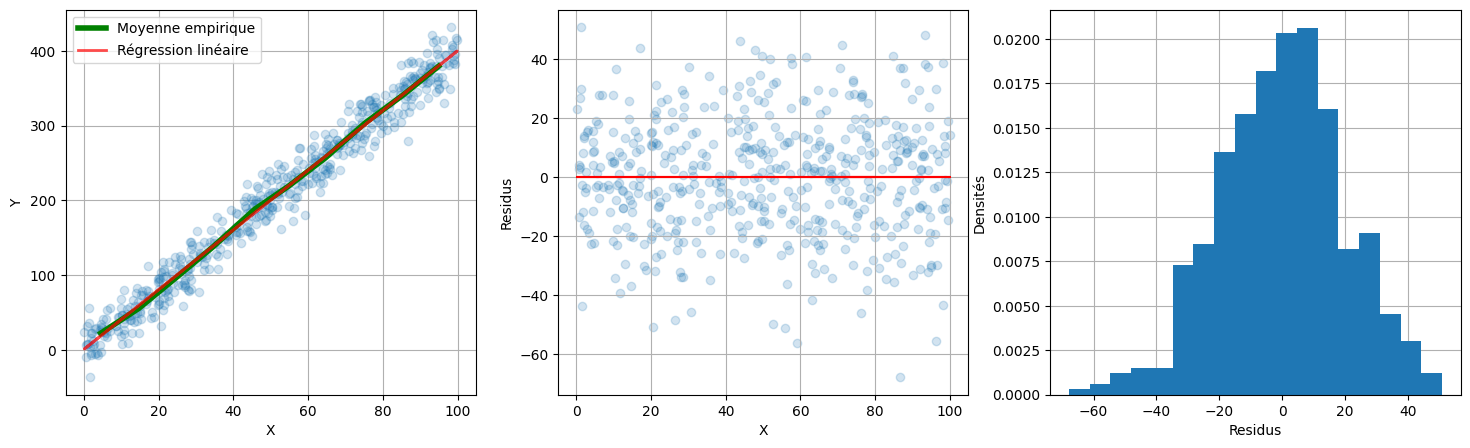

Pente de la régression linéaire: 3.99
Ordonnée à l'origine de la régression linéaire: 0.78
Moyenne des résidus: 0.00
Produit scalaire entre les résidus et les variables prédictives: 0.00
Erreur quadratique moyenne: 395.72


In [ ]:
# générons des données toy en se forcant à respecter une relation linéaire
NB_DATA_TOY = 500

def get_toy_data(nb_data, x_lim = [0, 100], coefs = [0.1, 4], noise = 20):
  x = np.random.uniform(x_lim[0], x_lim[1], nb_data)
  y = coefs[0] + coefs[1] * x + np.random.normal(0, noise, nb_data)
  return x, y

X_TOY, Y_TOY = get_toy_data(NB_DATA_TOY)

# réalisons une régression linéaire
linear_model = sk.linear_model.LinearRegression()
linear_model.fit(X_TOY.reshape(-1, 1), Y_TOY)

# fonction pour calculer le sample mean de notre régression linéaire
def get_sample_mean(x, y, step_size):
  min_x, max_x = np.min(x), np.max(x)
  bin_edges = np.arange(min_x, max_x + step_size, step_size)

  x_out = []
  y_out = []
  for i in range(len(bin_edges) - 1):
      left  = bin_edges[i]
      right = bin_edges[i + 1]
      idx = np.where((x >= left) & (x < right))[0]

      if len(idx) > 0:
          x_out.append(np.mean(x[idx]))
          y_out.append(np.mean(y[idx]))

  return np.array(x_out), np.array(y_out)

residues = Y_TOY - linear_model.predict(X_TOY.reshape(-1, 1))
mean_r = np.mean(residues)
fig, ax = plt.subplots(1,3, figsize=(18, 5))
ax[0].grid(zorder = 1)
ax[0].scatter(X_TOY, Y_TOY, zorder = 2, alpha = 0.2)
x_mean, y_mean = get_sample_mean(X_TOY, Y_TOY, 10)
ax[0].plot(x_mean, y_mean, color = 'green', linewidth = 4.0, label = 'Moyenne empirique')
ax[0].plot(X_TOY, linear_model.predict(X_TOY.reshape(-1, 1)), color = 'red', linewidth = 2.0, alpha = 0.7, label = 'Régression linéaire')
ax[0].legend()
ax[0].set_xlabel("X")

ax[0].set_xlabel("X")
ax[0].set_ylabel('Y')

ax[1].grid()
ax[1].scatter(X_TOY, residues, alpha=0.2)
ax[1].plot(X_TOY, mean_r * np.ones_like(X_TOY), color='red')
ax[1].set_xlabel("X")
ax[1].set_ylabel("Residus")


ax[2].grid(zorder = 1)
ax[2].hist(residues, zorder = 2, density=True, bins='auto')
ax[2].set_xlabel("Residus")
ax[2].set_ylabel('Densités')

plt.show()

print(f"Pente de la régression linéaire: {linear_model.coef_[0]:.2f}")
print(f"Ordonnée à l'origine de la régression linéaire: {linear_model.intercept_:.2f}")
print(f"Moyenne des résidus: {np.mean(residues):.2f}")
print(f"Produit scalaire entre les résidus et les variables prédictives: {np.sum(residues * X_TOY):.2f}")
print(f"Erreur quadratique moyenne: {np.mean(residues**2):.2f}")


✅ Quel bonheur ! Nous pouvons voir que la régression linéaire représente bien le comportement de la moyenne de nos données.

❓ Cependant, vous pouvez observez que les paramètres ne sont pas exactement les mêmes que ceux utilisés pour générer les données. Selon vous, à quoi cela est-il dû ? Quels sont les paramètres générant nos données qui influencent ceci ?

❓ Les résidus ont-ils une forme particulière dans le graphe du centre ? Qu'est-ce que cela veut dire ?

❓ Pouvons-nous voir une distribution particulière dans le graphe de droite ? Laquelle ?

❓ Observez les différentes valeurs affichées sous les graphes. Observez-vous des valeurs particulières ? Que se passe-t-il pour ces valeurs si vous modifiez les paramètres permettant de générer les données ?

Si vous ne savez pas quoi penser de tout cela pour l'instant, parcourir le reste du notebook devrait vous aider à y voir plus clair ! N'hésitez pas à revenir à cette cellule une fois le notebook entièrement parcouru ;).

> 🧠 Écrivez ici ce que vous en pensez !

# Comment les paramètres sont-ils trouvés ?

De manière un peu magique 🪄, la fonction de scikit-learn nous donne les paramètres de notre modèle de régression linéaire. Comment ceux-ci sont-ils obtenus ? Il y a en fait plusieurs manières de les obtenir !

Une première possibilité est d'utiliser le modèle Gaussien de la régression linéaire.

### 1️⃣ Modèle Gaussien de la régression linéaire

Le **modèle Gaussien de la régression linéaire** se base sur l'hypothèse que les données suivent une distribution Gaussienne autour des prédictions de la régression linéaire. Plus précisément, cela veut dire que:

$$Y \sim \mathcal{N}(\mu(X | \mathbf{\theta}), \sigma^2) \hspace{1cm} ⇒\hspace{1cm} Y = \mu(X | \mathbf{\theta}) + U, \quad U \sim \mathcal{N}(0, \sigma^2).$$

Afin d'identifier les meilleurs paramètres, il est possible d'utiliser les outils que nous avions explorés pour l'estimation ponctuelle. Plus précisément, nous souhaitons trouver les paramètres $\mathbf{\theta}$ qui maximise la fonction de vraissemblance $f(\mathbf{y} | \mathbf{X} = \mathbf{x})$:
$$f(\mathbf{y} | \mathbf{X} = \mathbf{x}; \mathbf{\theta}) = f(y_1, y_2, \cdots, y_n | X_1=x_1, X_2=x_2, \cdots, X_n=x_n; \mathbf{\theta}) \overset{\text{iid}}{=} \prod_{i=1}^{n}
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\!\left(
-\frac{(y_i - \mu(x_i| \mathbf{\theta}))^2}{2\sigma^2}
\right).$$

On a donc
$$\hat{\theta} = \underset{\theta}{\operatorname{argmax}}(f(\mathbf{y} | \mathbf{X} = \mathbf{x}; \mathbf{\theta})).$$

Il est ensuite courant de faire l'hypothèse de l'**homoscédasticité**. Cela revient à faire l'hypothèse que $\sigma$ est constante pour tout $x$. On peut donc trouver ces paramètres en maximisant la log-vraissemblance et en se débarassant des constantes:
$$\hat{\theta} = \underset{\theta}{\operatorname{argmax}}(\log(f(\mathbf{y} | \mathbf{X} = \mathbf{x}; \mathbf{\theta}))) = \underset{\theta}{\operatorname{argmin}} \sum_{i=1}^{n} (y_i - \mu(x_i| \mathbf{\theta}))^2.$$

Ceci nous montre que sous l'hypothèse d'homoscédasticité, le modèle gaussien revient à minimiser l'erreur quadratique moyenne !

### 2️⃣ Modèle linéaire par la méthode des moindres carrés (OLS)

Utiliser **la méthode des moindres carrés pour la régression linéaire** consiste à choisir les paramètres qui minimisent l'erreur quadratique moyenne (MSE).

$$\mathcal{L} = \mathrm{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \mu(x_i| \mathbf{\theta}))^2 = \frac{1}{n} \sum_{i=1}^{n}(y_i - \theta_0 - \theta_1 x_i)^2.$$

Pour minimiser cette erreur quadratique, on doit annuler la dérivée première par rapport à $\theta_0$ and $\theta_1$ :

$$\frac{\partial \mathcal{L}}{\partial \theta_0} = - \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{\theta_0} - \hat{\theta_1} x_i) = 0,$$

$$\frac{\partial \mathcal{L}}{\partial \theta_1} = - \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{\theta_0} - \hat{\theta_1} x_i) x_i = 0.$$


> 📌 On voit que postuler le _modèle_ gaussien et déterminer le MLE ou employer la _méthode_ OLS mènent ici au même estimateur $\hat{\theta}$. Nous allons rapidement voir que cela n'est valable que lorsque les hypothèses sont vérifiées.

Si l'on repart des deux égalités dérivées pour la méthode OLS, on remarque qu'elles peuvent être réécrites de la façon suivante:

$$\boxed{
 \sum_{i=1}^{n} \hat{U}_i = 0
}$$

$$\boxed{
 \sum_{i=1}^{n} x_i \hat{U}_i = 0.
}$$

On peut interpréter ces résultats de la manière suivante:

**👉 La somme des résidus est nulle.**

Cela signifie que la droite de régression passe "au centre" du nuage de points. Elle ne surestime pas plus souvent qu'elle ne sous-estime.

**👉 Les résidus sont orthogonaux aux variables prédictives $\mathbf{X}$.**


> ⚠️ Ces deux égalités sont valables **que l'on considère le modèle gaussien ou la méthode OLS**.


Ce résultat insique qu'il ne reste aucune relation linéaire exploitable entre les résidus $\hat{U}$ et les variables prédictives $\mathbf{X}$. C'est la raison pour laquelle on donne autant d'importance au nuage de points des résidus $\hat{U}(\mathbf{X})$. Il ne peut plus y avoir de relation linéaire dans ce schéma ! Cela permet donc de mettre en avant les possibles relations non-linéaires. Ainsi, si des patterns apparaissent dans ce graphe, cela signifie que (probablement) le modèle de régression linéaire n'est pas adapté.

## En résumé:

En guise de résumé, nous avons vu que la régression linéaire était caractérisées par certaines hypothèses et propriétés:

**🔶 Hypothèses**:
- **Indépendance des observations**: les paires $(x_i, y_i)$ sont indépendantes
- **Homoscédasticité**: $\sigma$ est indépendent de $x$
- **Absence de mutlicolinéarité**: en régression multiviariée, on suppose qu'il n'y a pas de correlation linéaire forte entre les différentes variables prédictives $(x_i, x_j)$

**🔷 Propriétés (Modèle gaussien _et_ méthode OLS)**:
- la moyenne des résidus est nulle
- les résidus sont orthogonaux aux variables prédictives



---

Le code suivant est utilisé dans les démonstrations suivantes. Il s'agit d'implémentations de modèles linéaires ainsi que de widgets. C'est ici que le modèle de génération de données est implémenté. Formalisons cela:

La moyenne est modélisée à l'aide d'un polynôme du second degré:
$$ y = \theta_0^{\text{mean}} + \theta_1^{\text{mean}} x + \theta_2^{\text{mean}} x^2 .$$

On bruite ces données à l'aide de bruit gaussien dont la variance est modélisée de la manière suivante:
$$\sigma^2(x) = \max(\theta_0^{\text{var}} + \theta_1^{\text{var}} x, 10^{-6}),$$
où $\{\theta_0^{\text{mean}}, \theta_1^{\text{mean}}, \theta_2^{\text{mean}}, \theta_0^{\text{var}}, \theta_1^{\text{var}} \}$ sont des paramètres que vous devez ajuster manuellement dans les différentes démos.

In [ ]:
class LinearRegression:
  def __init__(self, params = None):
    self.params = params

  def predict(self, x):
    assert self.params is not None

    x = np.asarray(x)

    if x.ndim > 1:
        if x.shape[1] == 1:
            x = x.flatten()
        else:
            raise ValueError("Input 'x' must be 1D or (N, 1) for polynomial prediction.")

    powers = np.arange(len(self.params))
    Xpow = x[:, None] ** powers[None, :]
    return Xpow @ self.params


  def __call__(self, x):
    return self.predict(x)


  def display(self, fig, ax, x, color = 'purple', **kwargs):
    x_1d = np.asarray(x).flatten()
    preds = self.predict(x_1d)

    if 'linewidth' not in kwargs:
        kwargs['linewidth'] = 2.0

    if 'alpha' not in kwargs:
        kwargs['alpha'] = 0.7

    ax.plot(x_1d, preds, color=color, **kwargs)


class MultipleFitModel():
  def __init__(self):
    self.params = {}
    self.models = []

  def add_param(self, key, value):
    if key not in self.params:
      self.params[key] = []
    self.params[key].append(value)

  def add_model(self, model: LinearRegression):
    self.models.append(model)
    self.add_param('intercept', model.params[0])
    self.add_param('slope', model.params[1])


  def display(self, fig, ax, x, **kwargs):

    if 'color' not in kwargs:
      kwargs['color'] = 'gray'

    if 'alpha' not in kwargs:
      kwargs['alpha'] = 0.1

    for model in self.models:
      preds = model.predict(x)
      ax.plot(x, preds, color='gray', alpha=0.1)


  def display_hist(self, fig, ax, key, **kwargs):

    if key not in self.params:
      raise ValueError(f"Key '{key}' not found in parameters.")

    data = self.params[key]

    if 'bins' not in kwargs:
      kwargs['bins'] = 'auto'

    if "density" not in kwargs:
      kwargs['density'] = True

    ax.hist(data, **kwargs)


class OLSLinearRegression(LinearRegression):
  def __init__(self, params = None, lin_reg = None):
    super().__init__(params)
    self.lin_reg = lin_reg

  def fit(self, x, y):
    x_2d = x.reshape(-1, 1)
    lin_reg = sk.linear_model.LinearRegression()
    lin_reg.fit(x_2d, y)

    self.params = np.array([lin_reg.intercept_, lin_reg.coef_[0]])
    self.lin_reg = lin_reg


class VarianceLinearModel(LinearRegression):
  def __init__(self, params = None, epsilon = 1e-6):
    super().__init__(params)
    self.epsilon = epsilon

  def predict(self, x):
    return np.maximum(super().predict(x), self.epsilon)

class GaussianLinearModel(LinearRegression):
  def __init__(self, params = None, x_variance = None, variance_model:VarianceLinearModel = None):
    super().__init__(params)

    self._x_variance = x_variance
    self.variance_model = variance_model


  def log_likelihood(self, thetas, x, y, sigmas):
    original_params = self.params
    self.params = thetas

    x_1d = np.asarray(x).flatten()
    preds = self.predict(x_1d)

    self.params = original_params

    residuals = y - preds
    a = -0.5 * (np.log(2*np.pi) + np.log(sigmas))
    b = - (residuals**2) / (2 * sigmas)

    return a + b

  def get_variance(self, x):
    return self.variance_model(x)



  def display(self, fig, ax, x, x_display, width_factor=0.08, pdf_alpha = 0.6, **kwargs):

    x_1d = np.asarray(x).flatten()

    preds = self.predict(x_1d)

    if 'linewidth' not in kwargs:
      kwargs['linewidth'] = 2.0

    if 'alpha' not in kwargs:
      kwargs['alpha'] = 0.7


    ax.plot(x_1d, preds, **kwargs)

    x_min, x_max = ax.get_xlim()
    width = (x_max - x_min) * width_factor

    mu0_array = self.predict(x_display)
    sigma0_array = np.sqrt(self.get_variance(x_display))

    for i in range(len(mu0_array)):
      mu0 = mu0_array[i]
      sigma0 = sigma0_array[i]


      y_grid = np.linspace(mu0 - 3*sigma0, mu0 + 3*sigma0, 200)

      pdf = norm.pdf(y_grid, mu0, sigma0)

      pdf_scaled = pdf / pdf.max()

      kwargs['alpha'] = 0.5

      if 'label' in kwargs:
        del(kwargs['label'])

      ax.fill_betweenx(
          y_grid,
          x_display[i],
          x_display[i] + width * pdf_alpha * pdf_scaled,
          **kwargs
      )


  def fit(self, x, y):

    def get_param_gaussian(thetas, x, y, sigmas):

      x_1d = np.asarray(x).flatten()

      original_params = self.params
      self.params = thetas
      preds = self.predict(x_1d)
      self.params = original_params

      # minimise la negative log-vraissemblance
      residuals = y - preds

      a = -0.5 * (np.log(2*np.pi) + np.log(sigmas))
      b = - (residuals**2) / (2 * sigmas)

      neg_log_likelihood = -np.sum(a + b)

      return neg_log_likelihood

    x_1d = np.asarray(x).flatten()

    # point initial: estimation de sklearn
    lin_reg = sk.linear_model.LinearRegression()
    lin_reg.fit(x.reshape(-1, 1), y)
    theta_init = np.array([lin_reg.intercept_, lin_reg.coef_[0]])

    sigmas = np.sqrt(self.get_variance(x_1d))

    result = minimize(
        fun=get_param_gaussian,
        x0=theta_init,
        args=(x_1d, y, sigmas),
        method='BFGS',
        options={
        'gtol': 1e-8,
        'eps': 1e-9,
        'maxiter': 500
        }
    )

    self.params = result.x


class MultipleFitModel():
  def __init__(self):
    self.params = {}
    self.models = []

  def add_param(self, key, value):
    if key not in self.params:
      self.params[key] = []
    self.params[key].append(value)

  def add_model(self, model: LinearRegression):
    self.models.append(model)
    self.add_param('intercept', model.params[0])
    self.add_param('slope', model.params[1])


  def display(self, fig, ax, x, **kwargs):

    if 'color' not in kwargs:
      kwargs['color'] = 'gray'

    if 'alpha' not in kwargs:
      kwargs['alpha'] = 0.1


    for model in self.models:
      preds = model.predict(x)
      ax.plot(x, preds, **kwargs)

      if 'label' in kwargs:
        del(kwargs['label'])


  def display_hist(self, fig, ax, key, **kwargs):

    if key not in self.params:
      raise ValueError(f"Key '{key}' not found in parameters.")

    data = self.params[key]

    if 'bins' not in kwargs:
      kwargs['bins'] = 'auto'

    if "density" not in kwargs:
      kwargs['density'] = True

    ax.hist(data, **kwargs)




In [ ]:
from typing import Optional

class DataGeneration:
    def __init__(self, mean_model: Optional[LinearRegression] = None, variance_model: Optional[VarianceLinearModel] = None):
        self.mean_model = mean_model
        self.variance_model = variance_model
        self.widgets = {}
        self.widget_init()

    def set_params_mean(self, params):
        self.mean_model = LinearRegression(params)

    def set_params_variance(self, params):
        self.variance_model = VarianceLinearModel(params)

    def generate_data(self, x_lim, nb_data = 1000):

        assert isinstance(self.mean_model, LinearRegression), "Mean model is not set."
        assert isinstance(self.variance_model, VarianceLinearModel), "Variance model is not set."

        x = np.random.uniform(x_lim[0], x_lim[1], nb_data)

        sigma_x = np.sqrt(self.variance_model(x))

        y = self.mean_model(x) + np.random.normal(0, sigma_x, nb_data)
        return x, y

    def widget_init(self):
        raise NotImplementedError()


    def widget_watch(self, update_function):
        for widget in self.widgets.values():
            widget.observe(update_function, names="value")


    def get(self, key):
        widget = self.widgets.get(key, None)
        return widget.value if widget else None


    def display_widgets_list(self):

      raise NotImplementedError()



class DataGenerationHomoscedasticity(DataGeneration):
  def __init__(self, mean_model: Optional[LinearRegression] = None, variance_model: Optional[VarianceLinearModel] = None, **kwargs):


    self.defaults_values = {
      "theta0_exp_slider":{
        'min': -10,
        'max': 10,
        'default': 0,
        'step': 0.1
      },
      "theta1_exp_slider":{
        'min': -10,
        'max': 10,
        'default': 4,
        'step': 0.1
      },
      "theta2_exp_slider":{
        'min': -10,
        'max': 10,
        'default': 0,
        'step': 0.1
      },
      "sigma0_var_slider":{
        'min': 0.1,
        'max': 10,
        'default': 0.5,
        'step': 0.1
      },
      "xlim_min_slider":{
        'min': -10,
        'max': 0,
        'default': 0,
        'step': 1
      },
      "xlim_max_slider":{
        'min': 0,
        'max': 10,
        'default': 10,
        'step': 1
      },
      "nb_data_slider":{
        'min': 30,
        'max': 500,
        'default': 30,
        'step': 10
      },
    }

    self.defaults_values.update(kwargs)

    super().__init__(mean_model = mean_model, variance_model = variance_model)


  def widget_init(self):

    nb_data_params = self.defaults_values['nb_data_slider']
    nb_data_slider = widgets.IntSlider(
        value=nb_data_params['default'],
        min=nb_data_params['min'],
        max=nb_data_params['max'],
        step=nb_data_params['step'],
        description='Number of Data Points',
        continuous_update=True
    )

    xlim_min_params = self.defaults_values['xlim_min_slider']
    xlim_min_slider = widgets.FloatSlider(
        value=xlim_min_params['default'],
        min=xlim_min_params['min'],
        max=xlim_min_params['max'],
        step=xlim_min_params['step'],
        description="X Min", continuous_update=True
    )

    xlim_max_params = self.defaults_values['xlim_max_slider']
    xlim_max_slider = widgets.FloatSlider(
        value=xlim_max_params['default'],
        min=xlim_max_params['min'],
        max=xlim_max_params['max'],
        step=xlim_max_params['step'],
        description="X Max", continuous_update=True
    )

    theta0_params = self.defaults_values['theta0_exp_slider']
    theta0_exp_slider = widgets.FloatSlider(
        value=theta0_params['default'],
        min=theta0_params['min'],
        max=theta0_params['max'],
        step=theta0_params['step'],
        description="θ₀ᵐᵉᵃⁿ", continuous_update=True
    )

    theta1_params = self.defaults_values['theta1_exp_slider']
    theta1_exp_slider = widgets.FloatSlider(
        value=theta1_params['default'],
        min=theta1_params['min'],
        max=theta1_params['max'],
        step=theta1_params['step'],
        description="θ₁ᵐᵉᵃⁿ", continuous_update=True
    )

    theta2_params = self.defaults_values['theta2_exp_slider']
    theta2_exp_slider = widgets.FloatSlider(
        value=theta2_params['default'],
        min=theta2_params['min'],
        max=theta2_params['max'],
        step=theta2_params['step'],
        description="θ₂ᵐᵉᵃⁿ", continuous_update=True
    )

    sigma0_params = self.defaults_values['sigma0_var_slider']
    sigma0_var_slider = widgets.FloatSlider(
        value=sigma0_params['default'],
        min=sigma0_params['min'],
        max=sigma0_params['max'],
        step=sigma0_params['step'],
        description="θ₀ᵛᵃʳ", continuous_update=True
    )

    self.widgets.update({
        "xlim_min_slider": xlim_min_slider,
        "xlim_max_slider": xlim_max_slider,
        "theta0_exp_slider": theta0_exp_slider,
        "theta1_exp_slider": theta1_exp_slider,
        "theta2_exp_slider": theta2_exp_slider,
        "sigma0_var_slider": sigma0_var_slider,
        "nb_data_slider": nb_data_slider
    })

  def display_widgets_list(self, output, others = []):

    xlim_min_slider = self.widgets["xlim_min_slider"]
    xlim_max_slider = self.widgets["xlim_max_slider"]
    theta0_exp_slider = self.widgets["theta0_exp_slider"]
    theta1_exp_slider = self.widgets["theta1_exp_slider"]
    theta2_exp_slider = self.widgets["theta2_exp_slider"]
    sigma0_var_slider = self.widgets["sigma0_var_slider"]
    nb_data_slider = self.widgets["nb_data_slider"]


    xlim_group = widgets.VBox([
        widgets.HTML("<b>📈 Data Range (X-Limits)</b>"),
        widgets.HBox([xlim_min_slider, xlim_max_slider])
    ])

    mean_model_group = widgets.VBox([
        widgets.HTML("<b>⚙️ True Mean Model Parameters</b>"),
        theta0_exp_slider,
        theta1_exp_slider,
        theta2_exp_slider,
    ])

    variance_model_group = widgets.VBox([
        widgets.HTML("<b>📉 True Var Model Parameters</b>"),
        sigma0_var_slider,
    ])

    simulation_display_group = widgets.VBox([
        widgets.HTML("<b>🎲 Simulation & Display</b>"),
        nb_data_slider,
        *others
    ])


    column_1 = widgets.VBox([
        mean_model_group,
        variance_model_group
    ])

    column_2 = widgets.VBox([
        xlim_group,
        simulation_display_group
    ])

    final_layout = widgets.VBox([
        widgets.HTML("<h2>🔬 Interactive Data Generation & Model Fitting Controls</h2>"),
        widgets.HBox([column_1, column_2]),
        output
    ])

    return final_layout


class DataGenerationHeteroscedasticity(DataGenerationHomoscedasticity):
  def __init__(self, mean_model: Optional[LinearRegression] = None, variance_model: Optional[VarianceLinearModel] = None, **kwargs):


    added = {"sigma1_var_slider":{
        'min': 0.,
        'max': 10,
        'default': 0.,
        'step': 0.1
      }}

    kwargs.update(added)


    super().__init__(mean_model = mean_model, variance_model = variance_model, **kwargs)




  def widget_init(self):

    super().widget_init()

    sigma1_params = self.defaults_values['sigma1_var_slider']
    sigma1_var_slider = widgets.FloatSlider(
        value=sigma1_params['default'],
        min=sigma1_params['min'],
        max=sigma1_params['max'],
        step=sigma1_params['step'],
        description="θ₁ᵛᵃʳ", continuous_update=True
    )


    self.widgets.update({
        "sigma1_var_slider": sigma1_var_slider,
    })

  def display_widgets_list(self, output, others = []):

    xlim_min_slider = self.widgets["xlim_min_slider"]
    xlim_max_slider = self.widgets["xlim_max_slider"]
    theta0_exp_slider = self.widgets["theta0_exp_slider"]
    theta1_exp_slider = self.widgets["theta1_exp_slider"]
    theta2_exp_slider = self.widgets["theta2_exp_slider"]
    sigma0_var_slider = self.widgets["sigma0_var_slider"]
    sigma1_var_slider = self.widgets["sigma1_var_slider"]
    nb_data_slider = self.widgets["nb_data_slider"]


    xlim_group = widgets.VBox([
        widgets.HTML("<b>📈 Data Range (X-Limits)</b>"),
        widgets.HBox([xlim_min_slider, xlim_max_slider])
    ])

    mean_model_group = widgets.VBox([
        widgets.HTML("<b>⚙️ True Mean Model Parameters</b>"),
        theta0_exp_slider,
        theta1_exp_slider,
        theta2_exp_slider,
    ])

    variance_model_group = widgets.VBox([
        widgets.HTML("<b>📉 True Var Model Parameters</b>"),
        sigma0_var_slider,
        sigma1_var_slider,
    ])

    simulation_display_group = widgets.VBox([
        widgets.HTML("<b>🎲 Simulation & Display</b>"),
        nb_data_slider,
        *others
    ])


    column_1 = widgets.VBox([
        mean_model_group,
        variance_model_group
    ])

    column_2 = widgets.VBox([
        xlim_group,
        simulation_display_group
    ])

    final_layout = widgets.VBox([
        widgets.HTML("<h2>🔬 Interactive Data Generation & Model Fitting Controls</h2>"),
        widgets.HBox([column_1, column_2]),
        output
    ])

    return final_layout


### Etude de l'hypothèse d'homoscedasticité
Assez de théorie ! Observons cela de manière concrète !

Comme expliqué ci-dessus, l'hypothèse d'homoscédasticité force à garder la variance dans le modèle gaussien fixe pour tout $x$. A l'opposé, l'hétéroscédasticité implique que cette variance va changer. Voici un exemple illustrant cette différence de manière marquée:

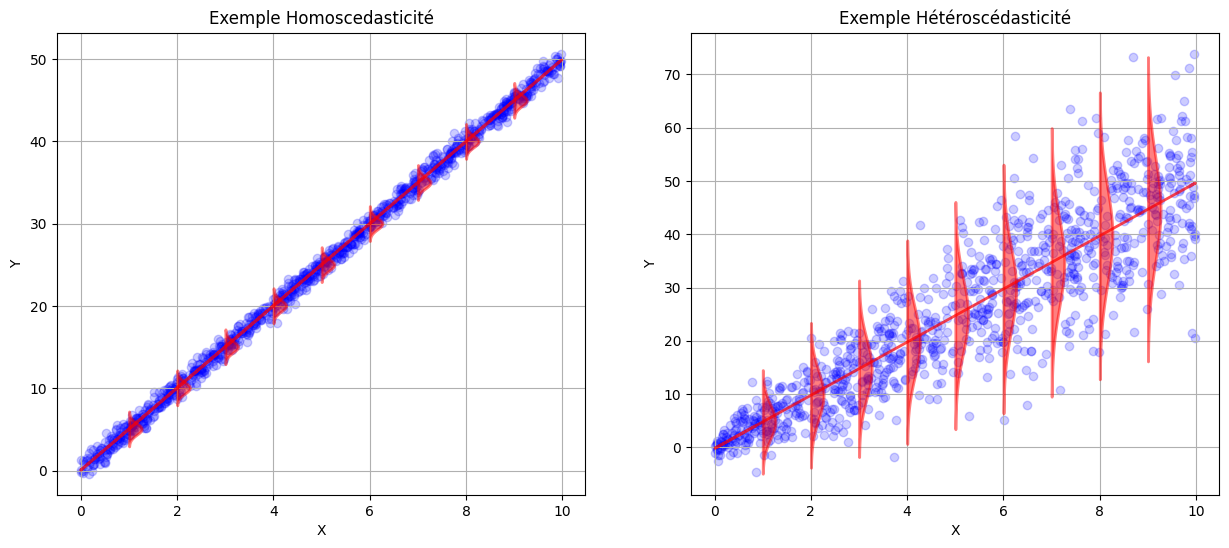

In [ ]:
nb = 1000
x_display_points = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
data_gen = DataGenerationHomoscedasticity()

parameters_mean = np.array([0, 5, 0])
parameters_var = np.array([0.5])

data_gen.set_params_mean(parameters_mean)
data_gen.set_params_variance(parameters_var)
x_homo, y_homo = data_gen.generate_data(x_lim=[0, 10], nb_data=nb)
GLinear_homo = GaussianLinearModel(variance_model=data_gen.variance_model)
x_data_1d = x_homo.flatten()

GLinear_homo.fit(x_data_1d, y_homo)

fig, axs = plt.subplots(1,2, figsize = (15, 6))
axs[0].grid()
axs[0].scatter(x_homo, y_homo, alpha=0.2, color = 'blue')
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Exemple Homoscedasticité")

GLinear_homo.display(
    fig, axs[0], x_data_1d,
    x_display=x_display_points,
    zorder=3,
    color='red',
    width_factor=0.04,
    label = 'Gaussian Regression (Homoscedasticity)'
    )

parameters_var = np.array([0.5, 10])

data_gen.set_params_mean(parameters_mean)
data_gen.set_params_variance(parameters_var)
x_hetero, y_hetero = data_gen.generate_data(x_lim=[0, 10], nb_data=nb)
GLinear_hetero = GaussianLinearModel(variance_model=data_gen.variance_model)
x_data_1d = x_hetero.flatten()
GLinear_hetero.fit(x_data_1d, y_hetero)


axs[1].grid()
axs[1].scatter(x_hetero, y_hetero, alpha=0.2, color = 'blue')
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Exemple Hétéroscédasticité")

GLinear_hetero.display(
    fig, axs[1], x_data_1d,
    x_display=x_display_points,
    zorder=3,
    color='red',
    width_factor=0.04,
    label = 'Gaussian Regression (Heteroscedasicity)'
    )

plt.show()


Il est malheureusement courant que l'on ne prette pas attention aux hypothèses sous-jacentes à nos modèles en pratique. Cependant, celles-ci peuvent se révéler primordiales au bon fonctionnement d'un modèle. Nous avons montré plus haut que minimiser l'erreur quadratique et maximiser la fonction de log-vraissemblance amenait au même modèle en régression linéaire lorsque l'hypothèse d'homoscédasticité est respectée.

Nous allons désormais observer ce qui se passe lorsque cette hypothèse n'est plus valide. Vous pouvez faire induire de l'hétéroscédasticité dans la démonstration ci-dessous à l'aide de $\theta_1^{\text{var}}$. Diminuer la valeur minimale de vos $x$ peut vous aider à accentuer les comportements liés à l'hétéroscédasticité.

In [ ]:
model_to_display_dropdown = widgets.Dropdown(
    options=['Both', 'OLS', 'Gaussian'],
    value='Both',
    description='Display Model',
    continuous_update=False
)

nb_gaussians_display_slider = widgets.IntSlider(
    value=5, min=3, max=10, step=1,
    description='Num Gaussians (Display)',
    continuous_update=True
)

# -----------------------------------

output = widgets.Output()
data_gen = DataGenerationHeteroscedasticity()


def update(change=None):
    with output:
        clear_output(wait=True)

        num_data_points = data_gen.get("nb_data_slider")
        model_display_choice = model_to_display_dropdown.value
        num_gaussians = nb_gaussians_display_slider.value
        x_lim = [data_gen.get("xlim_min_slider"), data_gen.get("xlim_max_slider")]
        model_display_choice = model_to_display_dropdown.value
        num_gaussians = nb_gaussians_display_slider.value

        params_model_exp = np.array([
            data_gen.get("theta0_exp_slider"),
            data_gen.get("theta1_exp_slider"),
            data_gen.get("theta2_exp_slider")
        ])

        params_model_var = np.array([
            data_gen.get("sigma0_var_slider"),
            data_gen.get("sigma1_var_slider")
        ])

        data_gen.set_params_mean(params_model_exp)
        data_gen.set_params_variance(params_model_var)

        x_data, y_data = data_gen.generate_data(x_lim=x_lim, nb_data=num_data_points)

        GLinear = GaussianLinearModel(variance_model=data_gen.variance_model)
        x_data_1d = x_data.flatten()

        GLinear.fit(x_data_1d, y_data)

        OLDLinear = OLSLinearRegression()
        OLDLinear.fit(x_data_1d, y_data)

        x_display_points = np.linspace(x_lim[0], x_lim[1], num_gaussians + 2)[1:-1]

        fig, axs = plt.subplots(1,2, figsize=(18, 6))

        axs[0].grid(zorder=1)
        axs[0].scatter(x_data, y_data, zorder=2, alpha=0.2)
        axs[0].set_xlim(x_lim)
        axs[1].grid(zorder=1)


        if model_display_choice == 'OLS' or model_display_choice == 'Both':
            OLDLinear.display(fig, axs[0], x_data_1d, zorder=3, color='blue', label = 'OLS Regression')
            residuals_ols = y_data - OLDLinear.predict(x_data_1d)
            axs[1].scatter(x_data, residuals_ols, zorder=2, alpha=0.2, color='blue')

        if model_display_choice == 'Gaussian' or model_display_choice == 'Both':
            GLinear.display(
                fig, axs[0], x_data_1d,
                x_display=x_display_points,
                zorder=3,
                color='red',
                width_factor=0.04,
                label = 'Gaussian Regression'
            )
            residuals_gaussian = y_data - GLinear.predict(x_data_1d)
            axs[1].scatter(x_data, residuals_gaussian, zorder=2, alpha=0.2, color='red')

        axs[0].set_xlabel("X")
        axs[0].set_ylabel('Y')
        axs[0].legend()

        axs[1].set_xlabel("X")
        axs[1].set_ylabel('Residues')
        axs[1].axhline(0, color='black', linestyle='--')

        plt.tight_layout()
        plt.show()


data_gen.widget_watch(update)
model_to_display_dropdown.observe(update, names='value')
nb_gaussians_display_slider.observe(update, names='value')

widget_box = data_gen.display_widgets_list(output = output, others = [model_to_display_dropdown, nb_gaussians_display_slider])

display(widget_box)


update()




❓ Que constatez-vous lorsque vous modifiez $\theta_0^{\text{var}}$ et $\theta_1^{\text{var}}$ ? Les résultats des deux régressions sont-ils les mêmes ?

❓ Faites désormais varier le terme quadratique dans le modèle générant les données tout en fixant $x \in [-2, 10]$. Quelle est la forme prise par les résidus ? Expliquez cela.

❓ En gardant le même setup, observez si les deux résultats sont identiques lorsque $\theta_1^{\text{var}} = 0$ ? Comme comprenez-vous cela ?

❓ Toujours dans le même setup, essayez maintenant de varier $\theta_1^{\text{var}}$. Vous devriez observer des droites totalement différentes. Quelles zone le modèle gaussien privillégie-t-il (indice: regardez la formulation de la fonction de vraisemblance) ? Y a-t-il aussi des zones privillégiées par la méthode OLS ?

> 🧠 Écrivez ici ce que vous en pensez !

## Focus sur le modèle obtenu par minimisation des moindres carrés

Dans la suite de ce notebook, nous allons nous concentrer exclusivement sur la méthode OLS.

Les deux égalités obtenues lors de la minimisation de la MSE permettent d'obtenir un **formulation explicite** des paramètres $\mathbf{\hat{\theta}}$. Dans le cadre d'une régression univariée, nous avons:

$$
\hat{\theta}_1
= \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}
= \frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(X)}
$$

$$
\hat{\theta}_0
= \bar{y} - \hat{\theta}_1 \bar{x}
$$


Bien que ces formules soient intéressantes en elles-mêmes (êtes-vous capables de les interpréter ?), nous allons nous focaliser sur une idée plus fondamentale :

👉 Les paramètres $\hat{\mathbf{θ}}$ sont obtenus à l'aide de statistiques.

Ainsi, on peut également les voir comme des **variables aléatoires**. Dans la cellule suivante, nous mettons cela en avant en samplant la distribution de nos paramètres $\hat{\mathbf{θ}}$ en générant à de multiple reprises les données avec le modèle. Chacune des droite est ensuite affichée. Notez qu'en pratique, vous pourriez faire la même chose avec du bootstrap par exemple ;)

🧪 La démo ci-dessous vous permet de visualiser comment les estimations de nos paramètres sont distribuées en fonction des mêmes conditions que la démo précédente. Essayez d'explorer cette dernière par vous-même ! Les résultats devraient être assez intuitifs :) Faites cependant attention aux échelles des axes.

In [ ]:
nb_draws = widgets.IntSlider(
    value=100, min=100, max=1000, step=30,
    description='Number of Draws',
    continuous_update=True
)


# -----------------------------------


def density_scatter( x , y, ax = None, fig = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    z[np.where(np.isnan(z))] = 0.0

    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.grid(zorder = 1)
    ax.scatter( x, y, c=z, **kwargs , zorder = 2)

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density of data')

    return ax


data_gen = DataGenerationHeteroscedasticity()
output = widgets.Output()

def update(change=None):
    with output:
        clear_output(wait=True)
        plt.close()

        num_data_points = data_gen.get("nb_data_slider")
        num_gaussians = nb_gaussians_display_slider.value
        nb_draws_values = nb_draws.value
        x_lim = [data_gen.get("xlim_min_slider"), data_gen.get("xlim_max_slider")]

        params_model_exp = np.array([
            data_gen.get("theta0_exp_slider"),
            data_gen.get("theta1_exp_slider"),
            data_gen.get("theta2_exp_slider")
        ])

        params_model_var = np.array([
            data_gen.get("sigma0_var_slider"),
            data_gen.get("sigma1_var_slider")
        ])

        data_gen.set_params_mean(params_model_exp)
        data_gen.set_params_variance(params_model_var)
        nb_draws_values = nb_draws.value

        x_data, y_data = data_gen.generate_data(x_lim=x_lim, nb_data=num_data_points)
        x_data_1d = x_data.flatten()

        mutliple_ols_models = MultipleFitModel()

        for nb in range(nb_draws_values):
          x_data, y_data = data_gen.generate_data(x_lim=x_lim, nb_data=num_data_points)
          x_data_1d = x_data.flatten()

          OLSLinear = OLSLinearRegression()
          OLSLinear.fit(x_data_1d, y_data)

          mutliple_ols_models.add_model(OLSLinear)

        fig, axs = plt.subplots(1,2, figsize=(18, 6))

        axs[0].grid(zorder=1)
        axs[0].scatter(x_data, y_data, zorder=2, alpha=0.2)
        axs[0].set_xlim(x_lim)
        axs[0].set_xlabel("X")
        axs[0].set_ylabel('Y')

        mutliple_ols_models.display(fig, axs[0], x_data_1d, zorder=3, color='blue')


        thetas_0_np = np.array(mutliple_ols_models.params['intercept'])
        thetas_1_np = np.array(mutliple_ols_models.params['slope'])

        # le code proposé vous permettrait aussi de voir les histogramme des différents paramètres de cette manière-ci
        #mutliple_ols_models.display_hist(
        #  fig, axs[1], 'slope', color = 'blue', zorder = 3, alpha = 0.5)

        axs[1].grid()
        axs[1].set_xlabel("θ₀")
        axs[1].set_ylabel("θ₁")

        density_scatter(thetas_0_np, thetas_1_np, axs[1], fig)

        plt.tight_layout()
        plt.show()


data_gen.widget_watch(update)
for slider in [
    nb_gaussians_display_slider, nb_draws
]:
    slider.observe(update, names="value")


display_box = data_gen.display_widgets_list(output = output, others = [nb_draws])

display(
    display_box
)

update()

❓ Qu'observez-vous au niveau de la distribution des estimations de nos paramètres lorsque l'on augmente le nombre de données générées ou la variance de notre modèle génératif ?

> 🧠 Écrivez ici ce que vous avez observé !

⚠️ Étant donné que nous obtenons une distribution pour nos paramètres, il est essentiel de souligner que **tous les autres outils statistiques du cours peuvent être utilisés ici**. Par exemple, il est possible d'établir des intervalles de confiance, faire des tests d'hypothèse, ...

## Information de Fisher

Le fait que l'on ait une variable aléatoire signifie que l'on peut également calculer l'information de Fisher des paramètres. Rappelons ce qui a déjà été introduit dans de précédents notebooks, l'information de Fisher quantifie à quel point les données nous renseignent sur la valeur des paramètres $\mathbf{\theta}$. Commençons par introduire le score $s(\mathbf{\theta})$. Ce dernier correspond à la dérivée de la fonction de log-vraisemblance et représente donc à quel point changer les paramètres $\mathbf{\theta}$ permet au modèle de mieux correspondre aux données.

$$s(\mathbf{\theta}) \overset{iid}{=} \sum_{i=1}^{n} \frac{∂\:\log \mathcal{L}(\theta; x_i ) }{∂\theta} = \sum_{i=1}^{n} s_i(\mathbf{\theta})$$

L'information de Fisher $I(\mathbf{\theta}^{*})$ est définie comme la variance du score. Or, puisque l'espérance du score est nulle pour $\mathbf{\theta}^{*} = \underset{\mathbf{\theta}}{\operatorname{argmax}}\; \mathcal{L}(\mathbf{\theta})$, on a:

$$I(\theta^{*}) = E[(s(\mathbf{\theta}^{*}) - E(s(\theta^{*})))^2] = - E \left[ \frac{\partial^{2}}{\partial \theta^{2}} \log \mathcal{L}(X;\theta) \,\bigg|\, \theta \right]$$

Ainsi, on peut lier l'information de Fisher à la courbure de la fonction de log-vraisemblance.

Cette notion se généralise également lorsque nous travaillons avec plusieurs paramètres. Cependant, cette fois, on n'a non plus un nombre mais une matrice !
La matrice d'information de Fisher est alors définie comme:

$$I(\theta)_{i,j} = -E[\frac{\partial \mathcal{L}(\mathbf{\theta})}{\partial \theta_i} \frac{\partial \mathcal{L}(\mathbf{\theta})}{\partial \theta_j}].$$

Dans notre cas (méthode OLS), en reprenant les équations détaillées plus tôt, on a:
$$s(\theta_0) = \frac{1}{\sigma^2} \sum_{i=1}^{n}(y_i - \theta_0 - \theta_1 x_i) \hspace{1cm} \& \hspace{1cm} s(\theta_1) = \frac{1}{\sigma^2} \sum_{i=1}^{n}(y_i - \theta_0 - \theta_1 x_i)x_i$$


$$
I(\mathbf{\theta}^*)
= \frac{1}{\sigma^2}
\begin{pmatrix}
n & \sum_{i=1}^n x_i \\
\sum_{i=1}^n x_i & \sum_{i=1}^n x_i^2
\end{pmatrix}.
$$


De même, on peut généraliser le Cramner-Rao Lower Bound en ne considérant non plus la variance mais la matrice de covariance. Avec un léger abus de language, on peut écrire:

$$\operatorname{Var}\left( \hat{\theta} \mid \mathbf{X} \right) \geq I^{-1}(\mathbf{\theta}).$$

Dans la démonstration suivante, l'information de Fisher est représentée par son ellipsoïde, observez le comportement de l'information de Fisher en fonction de différents paramètres tels que la variance de notre modèle génératif.

In [ ]:
def compute_fisher_information(X, variance):
    return (1 / variance) * (X.T @ X)

def get_log_likelihood(theta_0_grid, theta_1_grid, x, y, variance):

    theta_0_grid_arr = np.atleast_2d(theta_0_grid)
    theta_1_grid_arr = np.atleast_2d(theta_1_grid)

    residuals = y[:, None, None] - (theta_0_grid_arr[None, :, :] + theta_1_grid_arr[None, :, :] * x[:, None, None])
    ll = -0.5 / variance * np.sum(residuals**2, axis=0)
    return ll

def get_score_field(theta_0_grid, theta_1_grid, x, y, variance):

    residuals = y[:, None, None] - (theta_0_grid[None, :, :] + theta_1_grid[None, :, :] * x[:, None, None])

    U0 = (1 / variance) * np.sum(residuals, axis=0)
    U1 = (1 / variance) * np.sum(residuals * x[:, None, None], axis=0)

    return U0, U1

def get_coef_grid(x, y, delta_0=0.25, delta_1=.25, nb_steps=25, xlim=[-1,4], y_lim=[-10,30]):
    lin_model = sk.linear_model.LinearRegression().fit(x.reshape(-1, 1), y)

    theta_0_hat = lin_model.intercept_
    theta_1_hat = lin_model.coef_[0]

    x_min = np.min([xlim[0] + theta_0_hat, theta_0_hat - delta_0])
    x_max = np.max([xlim[1] + theta_0_hat, theta_0_hat + delta_0])

    y_min = np.min([y_lim[0] + theta_1_hat, theta_1_hat - delta_1])
    y_max = np.max([y_lim[1] + theta_1_hat, theta_1_hat + delta_1])
    theta_0_vec = np.linspace(x_min, x_max, nb_steps)
    theta_1_vec = np.linspace(y_min, y_max, nb_steps)

    return theta_0_vec, theta_1_vec, theta_0_hat, theta_1_hat


def get_ellipse(H, fun=None):
    eigvals, eigvecs = np.linalg.eig(H)

    if fun is None:
        axes = 1 / np.sqrt(eigvals)
    else:
        axes = fun(eigvals)

    t = np.linspace(0, 2*np.pi, 400)
    ellipse = np.vstack((axes[0] * np.cos(t), axes[1] * np.sin(t)))
    ellipse_rot = eigvecs @ ellipse

    return ellipse_rot


sigma0_var_slider = {
        'min': 0.1,
        'max': 1000,
        'default': 2,
        'step': 1
      }

data_gen = DataGenerationHomoscedasticity(sigma0_var_slider = sigma0_var_slider)
output = widgets.Output()


def update(change=None):
    with output:
        clear_output(wait=True)
        plt.close()

        num_data_points = data_gen.get("nb_data_slider")
        num_gaussians = nb_gaussians_display_slider.value
        nb_draws_values = nb_draws.value
        x_lim = [data_gen.get("xlim_min_slider"), data_gen.get("xlim_max_slider")]

        params_model_exp = np.array([
            data_gen.get("theta0_exp_slider"),
            data_gen.get("theta1_exp_slider"),
            data_gen.get("theta2_exp_slider")
        ])

        params_model_var = np.array([
            data_gen.get("sigma0_var_slider"),
        ])

        sigma0_var_slider = data_gen.get("sigma0_var_slider")

        data_gen.set_params_mean(params_model_exp)
        data_gen.set_params_variance(params_model_var)
        nb_draws_values = nb_draws.value

        x_data, y_data = data_gen.generate_data(x_lim=x_lim, nb_data=num_data_points)

        X = np.column_stack((np.ones(len(x_data)), x_data))
        I = compute_fisher_information(X, sigma0_var_slider)

        # vous pouvez aussi obtenir l'ellipsoïde de l'inverse de
        # la matrice de Fisher si vous le souhaitez :)
        # comment l'enterprétez-vous ?
        Cov = inv(I)
        print("La matrice de covariance assymptotique (inverse de la matrice d'information de Fisher) est ")
        print(Cov)
        ellipse_fisher = get_ellipse(I)

        # débarassez-vous de ce placeholder si vous voulez la visualiser
        ellipse_var = ellipse_fisher
        #ellipse_var = get_ellipse(Cov, fun=lambda x: x)

        min_x = np.min(ellipse_fisher[0, :])
        max_x = np.max(ellipse_fisher[0, :])
        min_y = np.min(ellipse_fisher[1, :])
        max_y = np.max(ellipse_fisher[1, :])

        # +1 and -1 are deltas for visualizing
        min_x = np.min([min_x, np.min(ellipse_var[0, :])])-1
        max_x = np.max([max_x, np.max(ellipse_var[0, :])])+1
        min_y = np.min([min_y, np.min(ellipse_var[1, :])])-1
        max_y = np.max([max_y, np.max(ellipse_var[1, :])])+1

        modelOLS = OLSLinearRegression()
        modelOLS.fit(x_data.reshape(-1, 1), y_data)

        fig = plt.figure(figsize=(20, 6))

        axs_0 = fig.add_subplot(1, 3, 1)
        axs_0.grid()
        axs_0.scatter(x_data, y_data)
        modelOLS.display(fig, axs_0, x_data)
        axs_0.set_title("Scatter Plot with OLS Fit")

        theta_0_vec, theta_1_vec, theta_0_hat, theta_1_hat = get_coef_grid(x_data, y_data, xlim=[min_x, max_x], y_lim=[min_y, max_y])
        theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vec, theta_1_vec)

        log_likelihood = get_log_likelihood(theta_0_grid, theta_1_grid, x_data, y_data, sigma0_var_slider)
        U0_grid, U1_grid = get_score_field(theta_0_grid, theta_1_grid, x_data, y_data, sigma0_var_slider)

        ellipse_x_fisher = ellipse_fisher[0, :] + theta_0_hat
        ellipse_y_fisher = ellipse_fisher[1, :] + theta_1_hat

        #ellipse_var_x = ellipse_var[0, :] + theta_0_hat
        #ellipse_var_y = ellipse_var[1, :] + theta_1_hat

        axs_1 = fig.add_subplot(1, 3, 2)
        axs_1.contourf(theta_0_grid, theta_1_grid, log_likelihood,
                        levels=50, cmap="viridis")

        axs_1.quiver(theta_0_grid, theta_1_grid,
                      U0_grid, U1_grid,
                      color="white", alpha=0.8,
                      label="Score field")

        axs_1.set_title("Log-Likelihood Heatmap")
        axs_1.set_xlabel("θ₀")
        axs_1.set_ylabel("θ₁")

        #axs_1.plot(ellipse_var_x, ellipse_var_y, "r", lw=3,
        #            label="Covariance ellipsoid (I⁻¹)")

        axs_1.plot(ellipse_x_fisher, ellipse_y_fisher, "b", lw=3,
                    label="Fisher information ellipsoid (I)")

        axs_1.scatter([theta_0_hat], [theta_1_hat], color="black",
                       s=80, marker="x", label="MLE")
        axs_1.legend()

        axs_2 = fig.add_subplot(1, 3, 3, projection='3d')

        axs_2.plot_surface(theta_0_grid, theta_1_grid, log_likelihood,
                        cmap="viridis", edgecolor="none", alpha=0.85)

        theta_0_ellipse_arr = ellipse_x_fisher.reshape(1, -1)
        theta_1_ellipse_arr = ellipse_y_fisher.reshape(1, -1)
        #theta_0_ellipse_arr = ellipse_var_x.reshape(1, -1)
        #theta_1_ellipse_arr = ellipse_var_y.reshape(1, -1)

        ll_ellipse_fisher = get_log_likelihood(theta_0_ellipse_arr, theta_1_ellipse_arr, x_data, y_data, sigma0_var_slider)[0, :]
        ll_ellipse_var = get_log_likelihood(theta_0_ellipse_arr, theta_1_ellipse_arr, x_data, y_data, sigma0_var_slider)[0, :]

        axs_2.plot(ellipse_x_fisher, ellipse_y_fisher, ll_ellipse_fisher,
            color="blue", linewidth=4, zorder=5, label=r"$\mathbf{I}$ Ellipsoid")

        #axs_2.plot(ellipse_var_x, ellipse_var_y, ll_ellipse_var,
        #    color="red", linewidth=4, zorder=5, label=r"$\mathbf{I}^{-1}$ Ellipsoid")


        axs_2.set_xlabel(r"$\theta_0$", fontsize=12)
        axs_2.set_ylabel(r"$\theta_1$", fontsize=12)
        axs_2.set_zlabel("log-likelihood", fontsize=12)

        axs_2.set_title("3D Surface of the Log-Likelihood", fontsize=14)

        axs_2.view_init(elev=30, azim=35)
        axs_2.legend()

        plt.tight_layout()
        plt.show()


data_gen.widget_watch(update)

display_box = data_gen.display_widgets_list(output = output, others = [])

display(display_box)

update()

> 🤔 Comment interpréter la démonstration suivante ?

En dehors du graphe habituel de la méthode OLS de la régression linéaire, deux graphes de la log-vraisemblance vous sont présentés. Le graphe central est en fait une projection verticale du graphe de droite. Le champ vectoriel dans ce dernier représente le score ($s(\mathbf{θ})$). Enfin, on représente la matrice d'information de Fisher via son ellipsoïde. Plus concrètement, on va afficher les points $\mathbf{u}$ étant solution de $\mathbf{u}^T I(\mathbf{\theta}) \mathbf{u} = 1$. Comme illustré sur la figure ci-dessous, on peut montrer que les projections horizontale et verticale des axes principaux renseignent sur l'écart-type $σ$ de nos paramètres.

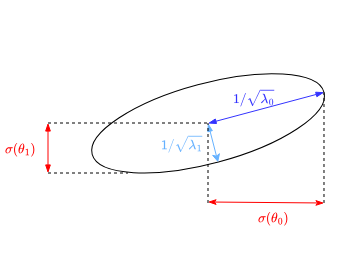

❓ Qu'observez-vous si vous modifiez la variance ou le nombre de données lorsque vous fixez $x\in [-1, 1]$ ? Interprétez.

❓ Faites de nouveau varier la variance et le nombre de données mais cette fois-ci en faisant varier le range des données. Qu'observez-vous en comparaison au point précédent ?


> 🧠 Écrivez ici ce que vous avez observé !

## 🤔 N'est-ce pas un peu simple ?

Une réaction assez naturelle lorsqu'on découvre la régression linéaire est de se demander si combiner linéairement les variables n'est pas une approche trop simple pour prédire des phénomènes réels.

 Une astuce consiste à appliquer la régression linéaire dans une base dépendant non-linéairement des données initiales. Si on utilise les fonctions non-linéaires $(f_1, f_2, ..., f_K)$, on peut obtenir le modèle de régression linéaire suivant:

$$\mu(\mathbf{x}) = \theta_0 + θ_1 f_1(x_1) + \theta_2 f_2(x_2) + ... + \theta_K f_K(x_K).$$

👉 Ceci reste bien une régression linéaire puisque les paramètres $\mathbf{\theta}$ apparaissent linéairement ! Si, par exemple, on avait $\theta_1^2$, cela ne serait plus une régression linéaire.

Nous allons illustrer ceci en utilisant un dataset tournant autour de l'astrophysique. Plus précisément, nous allons nous intéresser aux [parallaxes](https://fr.wikipedia.org/wiki/Parallaxe) ($X$), une mesure fondamentale permettant d'estimer la distance entre la Terre et une étoile ($Y$).



In [ ]:
file_path = "gaia-dr2-rave-35.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "solorzano/rave-dr5-gaia-dr2-consolidated",
  file_path,
)

100%|██████████| 38.4M/38.4M [00:00<00:00, 113MB/s]

Extracting zip of gaia-dr2-rave-35.csv...


In [ ]:
nb_data = 200
X_STARS = np.abs(df['parallax'][:nb_data].values)
Y_STARS = df['r_distance'][:nb_data].values

## Application de la régression linéaire

Nous allons maintenant appliquer une régression linéaire sur ce dataset afin de modéliser la relation entre la parallaxe et la distance qui nous sépare de l'étoile.

Comme vous allez le constater, cette relation n'est pas linéaire et une simple régression linéaire ne suffit pas à capturer correctement le phénomène. Nous allons alors également essayer d'appliquer la régression linéaire sur l'inverse de notre parallaxe. C'est-à-dire que nous allons ajuster les poids non plus avec les mesures de parallaxes $x$ mais leur inverse $1/x$.

/tmp/ipython-input-3067473833.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


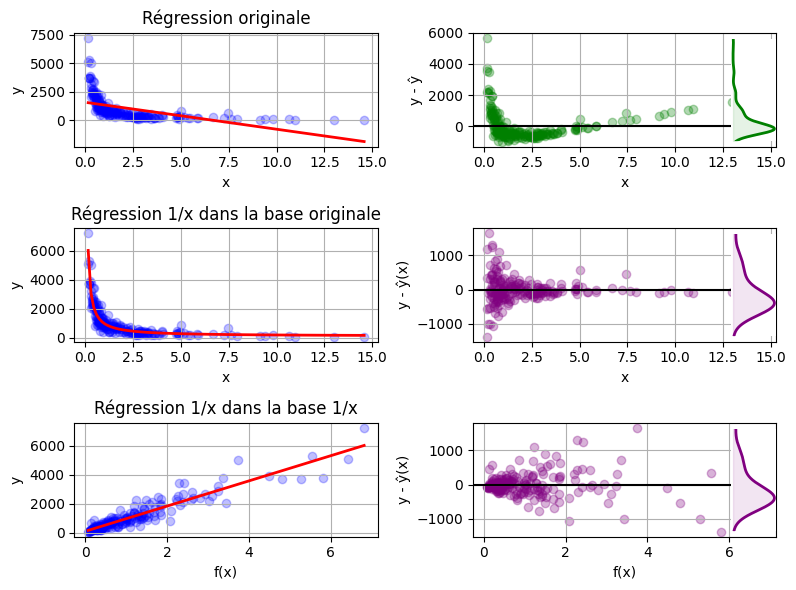

In [ ]:
def add_kde(fig, ax, data, **kwargs):
  ax_kde0 = inset_axes(ax, width="15%", height="90%", loc='right', borderpad=0)
  kde0 = stats.gaussian_kde(residuals)
  y_min, y_max = ax.get_ylim()
  y_kde0 = np.linspace(y_min, y_max, 200)
  x_kde0 = kde0(y_kde0)

  ax_kde0.plot(x_kde0, y_kde0, linewidth=2, **kwargs)
  ax_kde0.fill_betweenx(y_kde0, 0, x_kde0, alpha=0.1, **kwargs)

  ax_kde0.set_ylim(y_min, y_max)
  ax_kde0.set_xticks([])
  ax_kde0.set_yticks([])
  for spine in ax_kde0.spines.values():
      spine.set_visible(False)

fig, axs = plt.subplots(3, 2, figsize=(8, 6))

model = sk.linear_model.LinearRegression()
x_preds = np.linspace(np.min(X_STARS), np.max(X_STARS), 100)
model.fit(X_STARS.reshape(-1, 1), Y_STARS)

model2 = sk.linear_model.LinearRegression()
model2.fit((1/X_STARS).reshape(-1, 1), Y_STARS)

preds = model.predict(X_STARS.reshape(-1, 1))
residuals = Y_STARS - preds

preds2 = model2.predict(1/X_STARS.reshape(-1, 1))
residuals2 = Y_STARS - preds2


axs[0, 0].scatter(X_STARS, Y_STARS, color='blue', alpha=0.25)
axs[0, 0].plot(x_preds, model.predict(x_preds.reshape(-1, 1)),
                color='red', linewidth=2)
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].grid(True)
axs[0,0].set_title("Régression originale")

axs[0, 1].scatter(X_STARS, residuals, color='green', alpha=0.3)
axs[0, 1].axhline(0, color='black')
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y - ŷ")
axs[0, 1].grid(True)


axs[1, 0].scatter(X_STARS, Y_STARS, color='blue', alpha=0.25)
axs[1, 0].plot(x_preds, model2.predict(1/x_preds.reshape(-1, 1)),
               color='red', linewidth=2)
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
axs[1, 0].grid(True)
axs[1,0].set_title("Régression 1/x dans la base originale")


axs[2, 0].scatter(1/X_STARS, Y_STARS, color='blue', alpha=0.25)
axs[2, 0].plot(1/x_preds, model2.predict(1/x_preds.reshape(-1, 1)),
               color='red', linewidth=2)
axs[2, 0].set_xlabel("f(x)")
axs[2, 0].set_ylabel("y")
axs[2, 0].grid(True)
axs[2,0].set_title("Régression 1/x dans la base 1/x")

axs[1, 1].scatter(X_STARS, residuals2, color='purple', alpha=0.3)
axs[1, 1].axhline(0, color='black')
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y - ŷ(x)")
axs[1, 1].grid(True)

axs[2,1].scatter(1/X_STARS, residuals2, color='purple', alpha=0.3)
axs[2,1].axhline(0, color='black')
axs[2,1].set_xlabel("f(x)")
axs[2,1].set_ylabel("y - ŷ(x)")
axs[2,1].grid(True)

add_kde(fig, axs[0, 1], residuals, color = 'green')
add_kde(fig, axs[1, 1], residuals2, color='purple')
add_kde(fig, axs[2, 1], residuals2, color='purple')
plt.tight_layout()

plt.show()


❓ Pourquoi la régression linéaire n'était-elle pas adaptée dans le premier cas ? Comment pouvez-vous le constater dans le graphe des résidus ?

❓ La transformation de la base en $1/x$ a-t-elle résolu notre problème ?

> 🧠 Écrivez ici ce que vous avez observé !

## 🤔 Comment faire si on ne connait pas $f$ ?

La méthode précédente ne fonctionne que si l'on sait déjà quelle transformation non linéaire utiliser.  Dans la pratique, ceci n'est pas forcément le cas ! Une alternative consiste alors à travailler en régression multivariée. Par exemple, on peut considérer tous les polynômes pour un degré $n$ fixé.

Dans la démonstration suivante, nous allons examiner ce qui se passe lorsque l'on augmente progressivement le degré du polynôme. En plus des graphes habituels du nuage de points interpolé et des résidus, nous allons observer l'évolution de l'erreur quadratique moyenne $\mathrm{MSE}$. Dans un premier temps, nous allons regarder la $\mathrm{MSE}$ obtenue sur les mêmes données que celles utilisées pour ajuster les paramètres. Ensuite, nous allons aussi observer comment évolue la $\mathrm{MSE}$ calculée sur des données différentes de celles utilisées pour ajuster le modèle. On se réfère alors à cette mesure comme la $\mathrm{MSE}_{test}$

Note: pensez à modifier manuellement le degré du polynôme dans les cellules correspondantes. Les deux derniers graphes ($\mathrm{MSE}$ et $\mathrm{MSE}_{test}$) se rempliront petit à petit au fur et à mesure de vos essais.

In [ ]:
x = X_STARS
y = Y_STARS

x_test = np.abs(df['parallax'][-300:-200].values)
y_test = df['r_distance'][-300:-200].values
mse_memory = {}
mse_test_memory = {}


degree_slider = widgets.IntSlider(
    value=1, min=1, max=20, step=1,
    continuous_update=True,
    description='Max power'
)


output = widgets.Output()


def update(change=None):
    degree = degree_slider.value

    X = x.reshape(-1, 1)

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)

    model = sk.linear_model.LinearRegression()
    model.fit(X_poly, y)

    y_pred = model.predict(X_poly)
    residuals = y - y_pred

    mse = np.mean(residuals**2) / 10000

    X_test_poly = poly.fit_transform(x_test.reshape(-1,1))
    y_pred_test = model.predict(X_test_poly)
    residuals_test = y_test - y_pred_test
    mse_test = np.mean(residuals_test**2) / 10000

    if degree not in mse_memory:
        mse_memory[degree] = mse

    if degree not in mse_test_memory:
        mse_test_memory[degree] = mse_test

    mse_x = np.array(sorted(mse_memory.keys()))
    mse_y = np.array([mse_memory[d] for d in mse_x])
    mse_x_test = np.array(sorted(mse_test_memory.keys()))
    mse_y_test = np.array([mse_test_memory[d] for d in mse_x_test])

    with output:
        clear_output(wait=True)

        fig, axs = plt.subplots(1, 4, figsize=(18, 5))


        axs[0].scatter(x, y, color='blue', alpha=0.25, label='Data')

        x_plot = np.linspace(np.min(x), np.max(x), 400).reshape(-1, 1)
        x_plot_poly = poly.transform(x_plot)
        y_plot_pred = model.predict(x_plot_poly)
        axs[0].plot(x_plot, y_plot_pred, color='red', label='Regression')

        axs[0].set_title("Regression in original x-space")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("y")
        axs[0].grid(True)
        axs[0].legend()

        axs[1].scatter(x, residuals, color='purple', alpha=0.4)
        axs[1].axhline(0, color='black', linewidth=1)
        axs[1].set_title("Residuals in original space")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("y - ŷ")
        axs[1].grid(True)

        axs[2].plot(mse_x, mse_y, marker='o')
        axs[2].set_xlabel("Degré du polynome")
        axs[2].set_ylabel("MSE (1e4)")
        axs[2].grid(True)


        axs[3].plot(mse_x_test, mse_y_test, marker='o')
        axs[3].set_xlabel("Degré du polynome")
        axs[3].set_ylabel("MSE test(1e4)")
        axs[3].grid(True)

        plt.tight_layout()
        plt.show()


for slider in [degree_slider]:
    slider.observe(update, names='value')

display(
    widgets.VBox([
        degree_slider,
        output
    ])
)

update()


❓ Qu'observez-vous en regardant l'évolution de la MSE en fonction du degré maximal du polynome ? Arrivez-vous à expliquer cela en observant les prédictions et résidus ?

❓ Est-ce que le graphe de la MSE suit la tendance à laquelle vous vous attendiez ? Pourquoi le graphe n'est-il pas une fonction monotonément décroissante (indice: pensez à l'hypothèse de multicolinéarité)

❓ Comment expliquez-vous la différence entre les graphes de la $\mathrm{MSE}$ et de la $\mathrm{MSE}_{test}$

> 🧠 Écrivez ici ce que vous avez observé !

# Le danger de l'extrapolation

Les modèles prédictifs tels que la régression linéaire sont optimisés pour les données qui leur sont présentées. Si on applique désormais ce modèle sur des données provenant d'une autre distribution, nous n'avons aucune guarantie que le modèle nous donnera des résultats faisant sens et/ou satisfaisants.

Observons cela en pratique. Disons que le modèle n'a uniquement accès à des mesures de parallaxes comprises entre 0 et 1. Dans ce cadre, nous pouvons voir que la régression linéaire ne se généralise absolument pas sur des données se trouvant en dehors de cet intervalle.

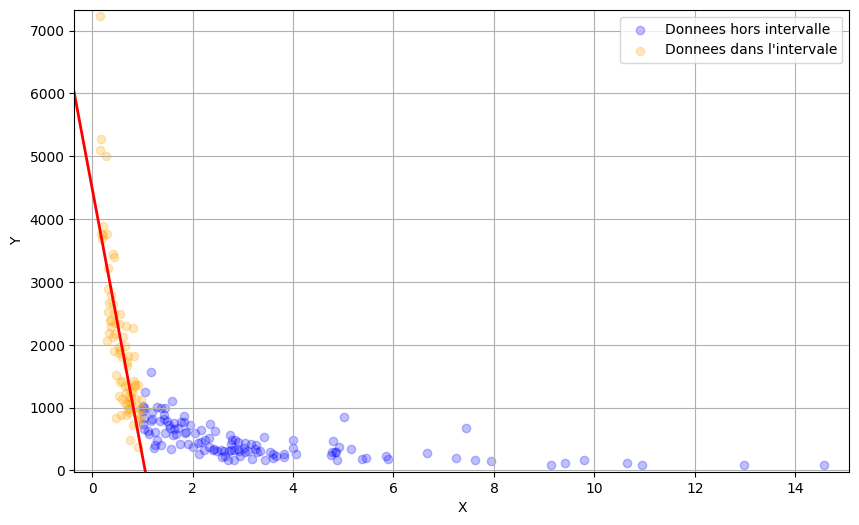

In [ ]:
cond = X_STARS < 1.0

x_min, x_max = np.min(X_STARS), np.max(X_STARS)
y_min, y_max = np.min(Y_STARS), np.max(Y_STARS)
x_selected = X_STARS[cond]
y_selected = Y_STARS[cond]

model = sk.linear_model.LinearRegression()
model.fit(x_selected.reshape(-1, 1), y_selected)

samples = np.linspace(x_min-1, x_max+1, 20)
preds = model.predict(samples.reshape(-1, 1))

fig, ax = plt.subplots(1,1,figsize = (10, 6))

ax.grid()
ax.scatter(X_STARS[~cond], Y_STARS[~cond], color='blue', alpha=0.25, label = "Donnees hors intervalle")
ax.plot(samples, preds, color='red', linewidth=2)
ax.scatter(x_selected, y_selected, color = 'orange', alpha = 0.25, label = "Donnees dans l'intervale")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_ylim([y_min-100, y_max+100])
ax.set_xlim([x_min-0.5, x_max+0.5])
plt.legend()
plt.show()

plt.show()

# Régression logistique

Lorsqu'un modèle prédictif prédit une variable continue, on dit qu'il fait de la régression. En pratique, il n'est pas rare d'également rencontrer des variables catégoriques, c'est-à-dire qui ne peuvent prendre des valeurs que dans certaines classes.

Par exemple, on peut vouloir:

$\hspace{1cm}$ 🩺 identifier si un patient est malade ou non.

$\hspace{1cm}$ 📧 catégoriser un mail en spam ou non.

$\hspace{1cm}$ ⭐ identifier le type spectral d'une étoile.

Lorsqu'un modèle prédictif prédit la classe de $Y$ sur base de $\mathbf{X} = \mathbf{x}$, on dit qu'il fait de la classification.

Fort heureusement, il est possible d'appliquer notre modèle linéaire pour faire de la classification à l'aide du modèle de régression logistique.

La régression logistique se concentre à estimer la probabilité d'appartenance à une classe. Dans le cadre de la classification binaire $y \in \{0, 1\}$, on appelle par convention

- $ y=1$, un succès,

- $ y=0$, un échec.


Comme dans le cas de la régression linéaire, on s'intéresse à l'espérance conditionnelle
$$
\mu(\mathbf{x}) = E(Y \mid \mathbf{X}=\mathbf{x}).
$$

Dans le cadre de la classification binaire, cette espérance prend la forme suivante:

$$
E(Y \mid \mathbf{X}=\mathbf{x})
= 1 \cdot P(Y=1 \mid \mathbf{X}=\mathbf{x})
+ 0 \cdot P(Y=0 \mid \mathbf{X}=\mathbf{x})
= P(Y=1 \mid \mathbf{X}=\mathbf{x})
$$

Autrement dit, prédire l'espérance conditionnelle de $Y$ revient à prédire une probabilité.

Nous ne pouvons pas prédire directement la probabilité à l'aide d'un modèle linéaire. En effet, nous risquerions d'obtenir des probabilités négatives, ce qui ne fait pas de sens. C'est pour cela que nous allons à la place prédire les log-odds.

$$
λ = \log\left(
\frac{P(Y=1 \mid \mathbf{X} = \mathbf{x})}
{1 - P(Y=1 \mid \mathbf{X} = \mathbf{x})}
\right) = \log\left(
\frac{\mu(\mathbf{x})}
{1 - \mu(\mathbf{x})}
\right)
= \operatorname{logit}(\mu(\mathbf{x})).
$$

Ce qui est intéressant avec les log-odds, c'est qu'elle prennent des valeurs dans $\mathbb{R}$ et qu'en les inversant, on obtient une valeur que l'on peut interpréter comme une probabilité (comme l'inverse ne prend des valeurs que entre $[0,1]$). Pour mettre les choses au clair, on a donc:

$$
λ = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ⋯ + \theta_K x_K
$$

$$
\mu(\mathbf{x} \mid \mathbf{\theta}) = \operatorname{logit}^{-1}(λ)
= \frac{1}{1 + \exp(-λ)} = \frac{\exp(λ)}{1+\exp(λ)}
$$


Une fois cette probabilité obtenue, on peut décider d'une valeur seuil (_threshold_) au-dessus de laquelle le modèle prédira un succès.

Dans la démonstration ci-dessous, nous allons essayer d'identifier si une mesure de parallaxe est fiable ou non. Pour ce faire, nous allons considérer la variable binaire
$$ Y = \begin{cases} 1 \; \text{ si } \frac{\text{parallax}}{\text{erreur_parallax}} > 20, \\ 0 \;\text{ sinon, }\end{cases} $$
qui représente le rapport entre le signal d'intérêt et le bruit entourant les mesures, que nous allons tenter de prédire à partir de la variable $X = \text{parallax}$. Ainsi, nous utilisons un modèle de régression logistique pour estimer la probabilité que la parallaxe soit fiable (_i.e._ la probabilité que $Y=1$). Une fois cette probabilité obtenue, il est possible de choisir le threshold au-dessus duquel une classe ou l'autre est choisie. Ceci peut se faire en regardant l'évolution d'un score unique caractérisant la qualité de notre modèle de classification. Ici, nous utiliserons la _précision_ qui correspond à la proportion de prédictions correctes (par rapport au nombre de prédictions total) : $$\mathrm{precision} = \frac{TP + TN}{TP + TN +FN +FP},$$
où $TP$ dénote les _true positives_, $FN$ les _false negatives_, etc.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(preds, y, thresholds):

    res = []
    for thresh in thresholds:
        y_pred = (preds >= thresh).astype(int)

        conf_mat = confusion_matrix(y, y_pred)

        tn, fp, fn, tp = conf_mat.ravel()
        acc =  (tp + tn) / (tp + tn + fp + fn)
        res.append((thresh, conf_mat, acc))

    return res

x = df["parallax"].values
par_err = df["parallax_error"].values
snr = x / par_err
y = (snr > 20).astype(int)

threshold_widget = widgets.FloatSlider(
    value=0.5, min=0, max=1, step=0.01,
    description='Threshold décision',
    continuous_update=True
)
output = widgets.Output()


model = LogisticRegression().fit(x.reshape(-1, 1), y)
preds_proba_x = model.predict_proba(x.reshape(-1, 1))[:, 1]
samples = np.linspace(np.min(x), np.max(x), 100)

preds_proba = model.predict_proba(samples.reshape(-1, 1))[:, 1]
thresholds = np.linspace(0,1, 100)
results = evaluate(preds_proba_x, y, thresholds)


def update(change=None):
  with output:
    clear_output(wait=True)
    plt.close()
    fig = plt.figure(figsize=(15, 7))
    gs = fig.add_gridspec(2, 3, height_ratios=[3, 1], hspace=0.3)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[0, 2])
    ax_hist_x = fig.add_subplot(gs[1, 0])
    ax_hist_proba = fig.add_subplot(gs[1, 1])

    ax0.grid()
    colors = ['red' if y[i] == 1 else 'blue' for i in range(len(preds_proba_x))]
    nb = 50000    # limite le nombre de points dans le nuage pour des raisons d'efficacité
    jitter = np.random.randn(nb) * 0.01
    ax0.scatter(x[:nb], y[:nb] + jitter, color=colors[:nb], alpha = 0.1, zorder=2)
    ax0.plot(samples, preds_proba, color='black', zorder=3)
    ax0.hlines(y=threshold_widget.value, xmin=ax0.get_xlim()[0], xmax=ax0.get_xlim()[1], color='black', linestyle='--', label = "Probabilite predite")
    ax0.set_xlabel("X")
    ax0.set_ylabel("Probabilité de prédire y=1")
    ax0.set_xlim([np.min(x), np.max(x)])
    ax0.scatter([], [], color='blue', label='y=0 (Non fiable)', alpha=1, zorder=2)
    ax0.scatter([], [], color='red', label='y=1 (Fiable)', alpha=1, zorder=2)
    ax0.legend()


    x_class_0 = x[y == 0]
    x_class_1 = x[y == 1]
    ax_hist_x.grid(zorder = 1)
    ax_hist_x.hist(x_class_0, bins=50, color='blue', alpha=0.5, density=True, label='y=0', zorder = 2)
    ax_hist_x.hist(x_class_1, bins=50, color='red', alpha=0.5, density=True, label='y=1', zorder = 2)
    ax_hist_x.set_xlabel("X")
    ax_hist_x.set_ylabel("Densité")
    ax_hist_x.legend()
    ax_hist_x.set_xlim(ax0.get_xlim())

    proba_class_0 = preds_proba_x[y == 0]
    proba_class_1 = preds_proba_x[y == 1]
    ax_hist_proba.grid(zorder = 1)
    ax_hist_proba.hist(proba_class_0, bins=50, color='blue', alpha=0.5, density=True, label='y=0', zorder = 2)
    ax_hist_proba.hist(proba_class_1, bins=50, color='red', alpha=0.5, density=True, label='y=1', zorder = 2)
    ax_hist_proba.set_xlabel("Probabilité prédite")
    ax_hist_proba.set_ylabel("Densité")
    ax_hist_proba.legend()
    ax_hist_proba.set_xlim([0, 1])
    ax_hist_proba.vlines(threshold_widget.value, ax_hist_proba.get_ylim()[0], ax_hist_proba.get_ylim()[1], color='black', linestyle='--')

    ax1.grid()
    ax1.plot([r[0] for r in results], [r[2] for r in results])
    ax1.set_title("Précision en fonction du threshold de décision")
    ax1.set_xlabel("Threshold de décision")
    ax1.set_ylabel("Précision")
    ax1.vlines(threshold_widget.value, 0, 1, color='black', linestyle='--')
    ax1.set_ylim([0,1])
    ax1.set_xlim([0,1])

    best_dist = float("inf")
    best_id = 0

    for i in range(len(results)):
      d = np.abs(results[i][0] - threshold_widget.value)
      if d < best_dist:
        best_dist = d
        best_id = i


    conf_mat = results[best_id][1]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    disp.plot(ax=ax2)

    plt.show()


for slider in [threshold_widget]:
    slider.observe(update, names='value')

display(
    widgets.VBox([
        threshold_widget,
        output
    ])
)

update()


❓ Observez les histogrammes en bas à gauche, qu'observez-vous ? Pouvez-vous identifier si le problème de classification binaire est simple à partir de cette observation.

❓ Faites varier la valeur seuil. Comment évolue la matrice de confusion ?

❓ Savez-vous expliquer pourquoi la valeur optimale est obtenue pour une valeur seuil de 0.4 environ ? Pour ce faire, regardez les histogrammes en bas à droite, qui représentent la répartition de nos données en fonction de la probabilité prédite par le modèle de régression logistique.

> 🧠 Écrivez ici ce que vous avez observé !